<a href="https://colab.research.google.com/github/DaGyeongChoi/2021_deeplearning/blob/main/05_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [실습05] 합성공 신경망(2)_Transfer Learning
## 휴먼지능정보공학과 201910841 최다경

## https://github.com/DaGyeongChoi

## 1.Settings
### 1) Important required libraries

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')
#!cd /content/gdrive/MyDrive/
#%cd /content/gdrive/MyDrive/ex_05/

In [1]:
!unzip '/content/horse-or-human.zip'

Archive:  /content/horse-or-human.zip
 extracting: test/horses/horse01-0.png  
 extracting: test/horses/horse01-1.png  
 extracting: test/horses/horse01-2.png  
 extracting: test/horses/horse01-5.png  
 extracting: test/horses/horse01-6.png  
 extracting: test/horses/horse01-8.png  
 extracting: test/horses/horse01-9.png  
 extracting: test/horses/horse02-2.png  
 extracting: test/horses/horse02-3.png  
 extracting: test/horses/horse02-4.png  
 extracting: test/horses/horse02-5.png  
 extracting: test/horses/horse02-7.png  
 extracting: test/horses/horse03-0.png  
 extracting: test/horses/horse03-1.png  
 extracting: test/horses/horse03-2.png  
 extracting: test/horses/horse03-3.png  
 extracting: test/horses/horse03-5.png  
 extracting: test/horses/horse03-6.png  
 extracting: test/horses/horse03-7.png  
 extracting: test/horses/horse03-9.png  
 extracting: test/horses/horse04-0.png  
 extracting: test/horses/horse04-5.png  
 extracting: test/horses/horse04-6.png  
 extracting: test/h

In [2]:
!unzip '/content/animal+utils.zip'

Archive:  /content/animal+utils.zip
  inflating: animal/animal.zip       
  inflating: animal/test/cats/images (22).jpg  
  inflating: animal/test/cats/images (23).jpg  
  inflating: animal/test/cats/images (24).jpg  
  inflating: animal/test/cats/images (25).jpg  
  inflating: animal/test/cats/images (26).jpg  
  inflating: animal/test/cats/images (27).jpg  
  inflating: animal/test/cats/images (28).jpg  
  inflating: animal/test/cats/images (29).jpg  
  inflating: animal/test/cats/images (30).jpg  
  inflating: animal/test/cats/images (31).jpg  
  inflating: animal/test/cats/images (32).jpg  
  inflating: animal/test/cats/images (33).jpg  
animal/test/cats/다운로드 (1).jpg:  mismatching "local" filename (animal/test/cats/сДГсЕбсДЛсЕосЖлсДЕсЕйсДГсЕ│ (1).jpg),
         continuing with "central" filename version
  inflating: animal/test/cats/다운로드 (1).jpg  
animal/test/cats/다운로드 (2).jpg:  mismatching "local" filename (animal/test/cats/сДГсЕбсДЛсЕосЖлсДЕсЕйсДГсЕ│ (2).jpg),
    

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
import utils

### 2) Hyperparameter

In [4]:
batch_size= 16 #64  #1
learning_rate = 0.0001
epoch = 20

n_node = 1024  # customized last layer 의 노드 수. 64, 128, 256, 512, 1024
dropratio = 0.5   # 얼마나 드랍시킬지 inverse keepratio 

imgsize = 256

## 2.Data Loader
### 트레이닝 데이터

In [5]:
#img_dir='../../../images/painting_dataset/real_artwork_divided_shffl_4K/Train'
#img_dir="animal/train"
img_dir="train"
train_data=dset.ImageFolder(img_dir, transforms.Compose([
            transforms.CenterCrop(imgsize*2), #CenterCop(512)
            transforms.RandomCrop(imgsize), #RandomCrop
            transforms.RandomHorizontalFlip(), #RandomHorizontalFlip
            transforms.Resize(imgsize),
            transforms.ToTensor()    
            ]))
print(train_data.__len__())
train_batch=data.DataLoader(train_data, batch_size=batch_size,
                           shuffle=True,num_workers=2)

226


### 고정된 데이터 셋

In [6]:
#2. Dev data
#img_dir='../../../images/painting_dataset/real_artwork_divided_shffl_4K/Valid'
# img_dir="animal/val"
img_dir="val"
dev_data=dset.ImageFolder(img_dir, transforms.Compose([
            transforms.CenterCrop(size=imgsize),
            transforms.Resize(imgsize),
            transforms.ToTensor()    
            ]))

dev_batch=data.DataLoader(dev_data, batch_size=batch_size,
                           shuffle=False,num_workers=2)

#3. Test data
# img_dir="animal/test"
img_dir="test"
test_data=dset.ImageFolder(img_dir, transforms.Compose([
            transforms.CenterCrop(size=imgsize),
            transforms.Resize(imgsize),
            transforms.ToTensor()    
            ]))

test_batch=data.DataLoader(test_data, batch_size=batch_size,
                           shuffle=False,num_workers=2)


nclass=len(train_data.classes)
print("# of classes: %d" %nclass)
print(train_data.classes)
print(train_data.class_to_idx)
print(train_data.__len__())

print("Training: %d, Dev: %d, Test: %d"
     %(train_data.__len__(), dev_data.__len__(), test_data.__len__()))

# of classes: 2
['horses', 'human']
{'horses': 0, 'human': 1}
226
Training: 226, Dev: 213, Test: 588


In [7]:
print(train_data.classes)
print(dev_data.classes)
print(test_data.classes)

['horses', 'human']
['horses', 'human']
['horses', 'human']


## 3.Model
### 1) Pretrained VGG Model

In [8]:
vgg=models.vgg19(pretrained =True)

for name,module in vgg.named_children():
    print(name)
    
print(list(vgg.children())[0])
print(list(vgg.children())[-1])


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth



features
avgpool
classifier
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU

In [9]:
print(list(vgg.children())[0][0])

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


### 2)Customized Fully Model

In [10]:
base_dim=64
fsize=int(imgsize/32)

class MyVGG(nn.Module):
    def __init__(self):
        super(MyVGG,self).__init__()
        #[0]: features(conv), [1]: classifier(fc)
        self.layer0=nn.Sequential(*list(vgg.children())[0])
        
        self.layer1=nn.Sequential(
            nn.Linear(8*base_dim*fsize*fsize,n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
        
            nn.Linear(n_node,n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
        
            nn.Linear(n_node,n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
            
            nn.Linear(n_node, nclass),        
            )
        
        for m in self.layer1.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)
            if isinstance(m, nn.Linear):
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)
                    
    def forward(self,x):
        out=self.layer0(x)
        out=out.view(out.size(0),-1)
        out=self.layer1(out)
        return out   

### 3) Model on GPU

In [11]:
model=MyVGG().cuda()

for params in model.layer0.parameters():
    params.required_grad =False
    
for params in model.layer1.parameters():
    params.required_grad =True

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


In [12]:
for name in model.children():
    print(name)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## 4. Optimizer & Loss

In [13]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.layer1.parameters(), lr=learning_rate)

## 5. Train

In [15]:
import utils 
total_time=0
disp_step=10

to_train = True
if (to_train == False):
    # netname='./nets/catdog_vgg19_10.pkl'
    netname='./nets/horsehuman.pkl'
    model=torch.load(netname)
else:
    print("3 layer, n_node: %d, dropratio: %.2f" %(n_node,dropratio))
    model.eval()
    train_corr=utils.ComputeCorr(train_batch, model)
    dev_corr=utils.ComputeCorr(dev_batch, model)
    test_corr=utils.ComputeCorr(test_batch, model)
    print("Correct of train: %.2f, dev: %.2f, test: %.2f"
         %(train_corr, dev_corr, test_corr))
    model.train()
    netname='./nets/horsehuman1'
    
    x_epoch=[]
    y_train_err=[]
    y_dev_err=[]
    y_test_err=[]
    
    x_epoch.append(0)
    y_train_err.append(100.0-train_corr)
    y_dev_err.append(100.0-dev_corr)
    y_test_err.append(100.0-test_corr)
    
    for i in range(epoch):
        start_time=time.time()
        print("%d.."%i),
        for img,label in train_batch:
            img=Variable(img).cuda()
            label=Variable(label).cuda()
            
            optimizer.zero_grad()
            output=model(img)
            loss=loss_func(output,label)
            loss.backward()
            optimizer.step()
            
        end_time=time.time()
        duration=end_time-start_time
        total_time += duration
        if (i % disp_step==0) or (i==epoch-1):
            torch.save(model, netname+'_%d.pkl'%i,)
            print("\n[%d/%d] loss: %.3f, " %(i, epoch, (loss.cpu()).data.numpy())),
            model.eval()
            train_corr = utils.ComputeCorr(train_batch, model)
            dev_corr = utils.ComputeCorr(dev_batch, model)
            test_corr = utils.ComputeCorr(test_batch, model)
            print("Correct of train: %.2f, dev: %.2f, test: %2f, "
                 %(train_corr, dev_corr, test_corr)),
            model.train()
            print("time: %.2f sec.." %(total_time))
            
            x_epoch.append(i+1)
            y_train_err.append(100.0-train_corr)
            y_dev_err.append(100.0-dev_corr)
            y_test_err.append(100.0-test_corr)
        print("Total time: %.2f sec" %total_time)

3 layer, n_node: 1024, dropratio: 0.50
Correct of train: 76.99, dev: 85.92, test: 82.14
0..

[0/20] loss: 0.422, 
Correct of train: 93.36, dev: 97.18, test: 98.469383, 
time: 4.73 sec..
Total time: 4.73 sec
1..
Total time: 9.52 sec
2..
Total time: 14.33 sec
3..
Total time: 19.15 sec
4..
Total time: 23.99 sec
5..
Total time: 28.83 sec
6..
Total time: 33.69 sec
7..
Total time: 38.57 sec
8..
Total time: 43.46 sec
9..
Total time: 48.38 sec
10..

[10/20] loss: 1.287, 
Correct of train: 98.23, dev: 99.53, test: 99.149658, 
time: 53.32 sec..
Total time: 53.32 sec
11..
Total time: 58.28 sec
12..
Total time: 63.23 sec
13..
Total time: 68.16 sec
14..
Total time: 73.11 sec
15..
Total time: 78.02 sec
16..
Total time: 82.94 sec
17..
Total time: 87.86 sec
18..
Total time: 92.73 sec
19..

[19/20] loss: 1.457, 
Correct of train: 99.56, dev: 99.53, test: 100.000000, 
time: 97.63 sec..
Total time: 97.63 sec


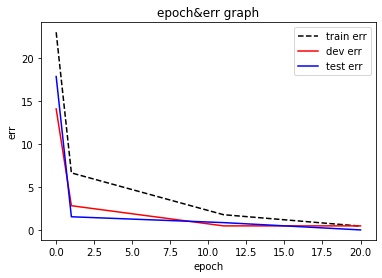

In [16]:
if (to_train):
    plt.plot(x_epoch, y_train_err, color='black', label='train err', linestyle='--')
    plt.plot(x_epoch, y_dev_err, color='red', label='dev err')
    plt.plot(x_epoch, y_test_err, color='blue', label='test err')
    
    plt.xlabel('epoch')
    plt.ylabel('err')
    plt.title('epoch&err graph')
    plt.legend(loc="upper right")
    plt.show()

## 6.Evaluation for dev & test data

Normalized confusion matrix


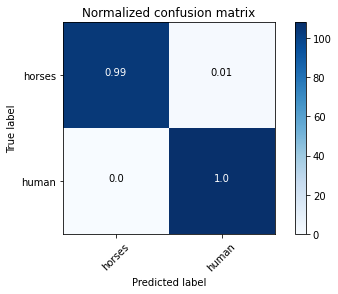

Confusion matrix, without normalization


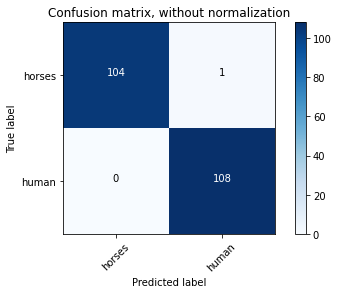

	 acc  |	 pre  |	 rec  |	 f1
 horses: 1.00 |	 1.00 |	 0.99 |	 1.00
 human: 1.00 |	 0.99 |	 1.00 |	 1.00
*accuracy: 1.00, precision: 1.00, recall: 1.00, *f1 score: 1.00
[AP]
horses: 1.00
human: 1.00

[mAP] 1.000
[miAP] 0.998


(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [17]:
model.eval()
utils.EvaluateClassifier(dev_batch, model, dev_data.classes, batch_size)

Normalized confusion matrix


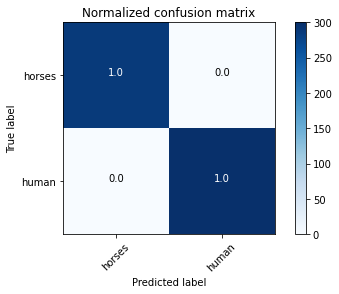

Confusion matrix, without normalization


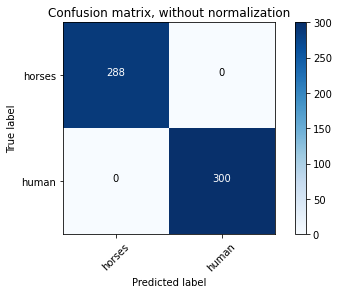

	 acc  |	 pre  |	 rec  |	 f1
 horses: 1.00 |	 1.00 |	 1.00 |	 1.00
 human: 1.00 |	 1.00 |	 1.00 |	 1.00
*accuracy: 1.00, precision: 1.00, recall: 1.00, *f1 score: 1.00
[AP]
horses: 1.00
human: 1.00

[mAP] 1.000
[miAP] 1.000


In [18]:
model.eval()
_, _,_ = utils.EvaluateClassifier(test_batch, model, test_data.classes, batch_size)

Category: horses
 True predicted images/total horses category: 104 / 105
Predicted probability:
[0.98419726 0.01580276]


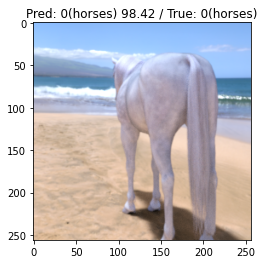

Predicted probability:
[0.9988796  0.00112041]


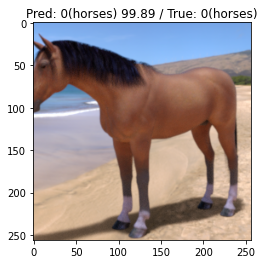

 False predicted images/total horses category: 1 / 105
Predicted probability:
[0.24878326 0.75121677]


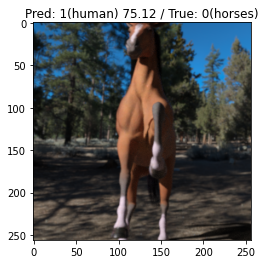

Category: human
 True predicted images/total human category: 108 / 108
Predicted probability:
[0.00599949 0.9940005 ]


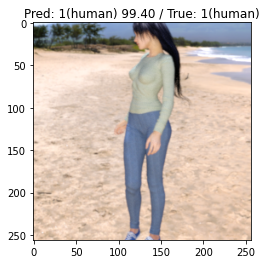

Predicted probability:
[0.00731367 0.99268633]


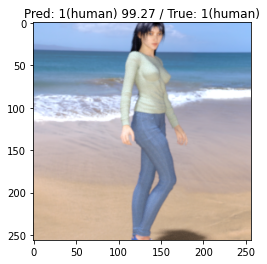

 False predicted images/total human category: 0 / 108


In [19]:
utils.VisTFPred(dev_batch, model, test_data.classes, batch_size, i_n=2)